In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import sasc.analyze_helper
# from sasc.modules.fmri_module import convert_module_num_to_voxel_num

**Note: not sure these are properly adjusted for the trim**

In [2]:
pilot_name = 'pilot2_story_data.pkl'
# pilot_name = 'pilot3_story_data.pkl'

stories_data_dict = joblib.load(
    join(sasc.config.RESULTS_DIR, 'processed', pilot_name))
if pilot_name == 'pilot2_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230702'

In [3]:
# load responses
interaction_story_idxs = np.where(
    np.array(stories_data_dict['story_setting']) == 'interactions')[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in interaction_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

100%|██████████| 2/2 [00:33<00:00, 16.59s/it]


In [4]:
def get_resp_chunks_list(stories_data_dict, resps_dict, interaction_story_idxs):
    resp_chunks_list = []
    for story_num in interaction_story_idxs:
        story_metadata = stories_data_dict["rows"][story_num]
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                '_resps', '')
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # paragraphs = stories_data_dict["paragraphs"][story_num]
        assert len(paragraphs) == len(story_metadata)
        resp_chunks = sasc.analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2, apply_offset=False)
        resps_one = resp_chunks[1::3]
        resps_both = resp_chunks[2::3]
        resps_two = resp_chunks[3::3]

        expl1 = np.array(stories_data_dict['expl1'][story_num].values)
        expl2 = np.array(stories_data_dict['expl2'][story_num].values)
        voxel_num1 = stories_data_dict['voxel_num1'][story_num].values
        voxel_num2 = stories_data_dict['voxel_num2'][story_num].values
        args = np.argsort(expl1)

        print(args, expl1)
        expl1 = expl1[args]
        expl2 = expl2[args]
        voxel_num1 = voxel_num1[args]
        voxel_num2 = voxel_num2[args]
        resps_one = [resps_one[a] for a in args]
        resps_both = [resps_both[a] for a in args]
        resps_two = [resps_two[a] for a in args]
        resp_chunks_list.append(
            (resps_one, resps_both, resps_two))

    return resp_chunks_list, expl1, expl2, voxel_num1, voxel_num2


resp_chunks_list_full, expl1, expl2, voxel_num1, voxel_num2 = get_resp_chunks_list(
    stories_data_dict, resps_dict, interaction_story_idxs)
# resp_chunks_arr = np.array(resp_chunks_list).mean(axis=0)
# expls = stories_data_dict["rows"][0]  # .sort_values(by="expl")["expl"].values

[0 4 1 2 3] ['emotional expression' 'locations' 'physical injury or trauma' 'time'
 'laughter']
[4 1 2 3 0] ['time' 'laughter' 'locations' 'physical injury or trauma'
 'emotional expression']


### Visualize curves

In [5]:
def make_plot(resp_chunks_list, expls):
    resps_rep_means = []
    resps_rep_all = []
    C = 6
    R = 3
    viz_mean = True
    # resp_chunks_list (n_stories, n_voxels (driving), n_voxels (resp), n_time)
    n_voxels = len(resp_chunks_list[0])
    n_stories = len(resp_chunks_list)
    for voxel_num in range(n_voxels):
        plt.subplot(R, C, voxel_num + 1)
        resps_rep = []
        for story_num in range(n_stories):
            # print(resp_chunks_list[story_num][voxel_num])
            resps_rep.append(resp_chunks_list[story_num][voxel_num][voxel_num])
        resps_rep = sorted(resps_rep, key=lambda x: len(x))

        # interpolate each story to 100 time points
        resps_rep_interp = []
        for resp_rep in resps_rep:
            resps_rep_interp.append(
                np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(resp_rep)),
                          resp_rep))
        resps_rep_interp = np.array(resps_rep_interp)
        resps_rep_mean = np.nanmean(resps_rep_interp, axis=0)

        # print('shape', resps_rep_mean.shape)
        if viz_mean:
            plt.plot(resps_rep_mean, color='gray', alpha=0.5)
            plt.axhline(0, color='gray', linestyle='--')
            plt.ylim(-1, 1)

            if voxel_num < C * (R - 1):
                plt.xticks([])
            else:
                plt.xticks([0, 100], ['Start', 'End'])
        else:
            cmap = sns.color_palette("Blues", as_cmap=True)
            for i, resp in enumerate(resps_rep):
                plt.plot(resp, color=cmap(i / len(resps_rep)), alpha=0.5)
            plt.ylim(-3, 3)

        if voxel_num % C != 0:
            plt.yticks([])
        else:
            plt.ylabel('Mean response')

        resps_rep_means.append(resps_rep_mean)
        resps_rep_all.append(resps_rep)
        plt.title(expls[voxel_num], fontsize='small')

    plt.subplot(R, C, voxel_num + 2)
    plt.title('Mean', color='C0')
    plt.plot(np.array(resps_rep_means).mean(axis=0), color='C0')
    plt.grid()
    plt.ylim(-1, 1)
    plt.xticks([0, 100], ['Start', 'End'])
    plt.tight_layout()


# n_stories = 1
# plt.figure(figsize=(13, 6), dpi=300)
# resp_chunks_list = [resp_chunks_list_full[i][0]
#                     for i in range(len(resp_chunks_list_full))]
# expls = expl1
# resp_chunks_list = [resp_chunks_list_full[i][1]
#                     for i in range(len(resp_chunks_list_full))]
# expls = expl1
# make_plot(resp_chunks_list, expls)

In [6]:
# def average_chunks(resp_chunks_list_full):
#     # interpolate each story to 100 time points

#     # story_num x 3 x paragraph_num x voxel_num x time -> 3 x paragraph_num x voxel_num x time
#     resp_chunks_list = []
#     # for
#     # for paragraph_num in

#     resps_rep = []
#     for story_num in range(len(resp_chunks_list_full)):
#         #     # print(resp_chunks_list[story_num][voxel_num])
#         resps_rep.append(
#             resp_chunks_list_full[story_num][0][paragraph_num][v1])


# avg = average_chunks(resp_chunks_list_full)

In [7]:
def avg_interpolated_lists(resps_rep):
    resps_rep = sorted(resps_rep, key=lambda x: len(x))
    resps_rep = [x for x in resps_rep if len(x) > 0]
    resps_rep_interp = []
    for resp_rep in resps_rep:
        resps_rep_interp.append(
            np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(resp_rep)),
                      resp_rep))
    resps_rep_interp = np.array(resps_rep_interp)
    resps_rep_mean = np.nanmean(resps_rep_interp, axis=0)
    return resps_rep_mean.tolist()

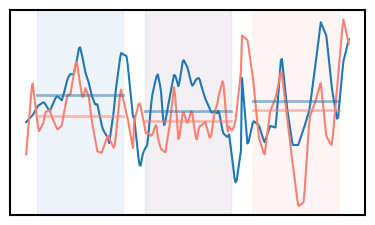

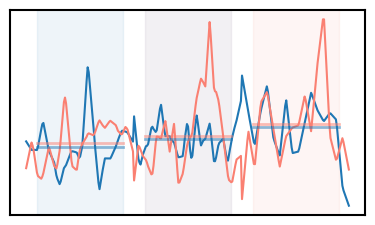

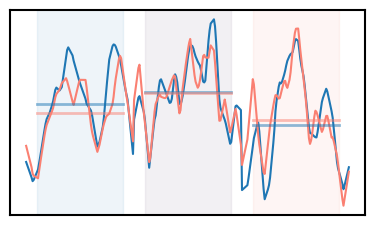

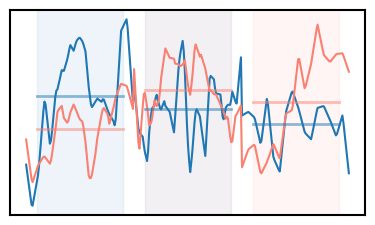

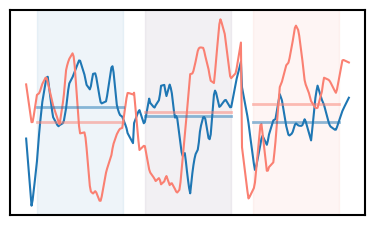

In [13]:
story_num = 1
paragraph_num = 2
# for story_num in range(2):
for paragraph_num in range(5):
    plt.figure(figsize=(4, 2.5))
    [one, both, two] = resp_chunks_list_full[story_num]
    v1 = voxel_num1[paragraph_num]
    v2 = voxel_num2[paragraph_num]

    n = len(one[paragraph_num][v1])
    c0 = 'C0'
    c1 = 'salmon'
    vals_v1 = [avg_interpolated_lists([resp_chunks_list_full[0][i][paragraph_num]
                                      [v1], resp_chunks_list_full[1][i][paragraph_num][v1]]) for i in range(3)]
    vals_v2 = [avg_interpolated_lists([resp_chunks_list_full[0][i][paragraph_num]
                                       [v2], resp_chunks_list_full[1][i][paragraph_num][v2]]) for i in range(3)]

    #
    n = 0
    plt.plot(np.concatenate(vals_v1), color=c0)
    plt.plot(np.concatenate(vals_v2), color=c1)
    ylim = plt.gca().get_ylim()
    for i in range(3):
        offset = len(vals_v1[i])
        kwargs = dict(
            alpha=0.5,
            lw=2
        )
        trim = 10
        colors = ['C0', '#5D3F6A', 'salmon']
        if trim > 0:
            plt.plot([n + trim, n + offset - trim], [np.mean(vals_v1[i]),
                     np.mean(vals_v1[i])], color=c0, **kwargs)
            plt.plot([n + trim, n + offset - trim], [np.mean(vals_v2[i]),
                     np.mean(vals_v2[i])], color=c1, **kwargs)
            # fill range without changing ylim
            # get current ylim

            plt.fill_between([n + trim, n + offset - trim], -
                             100, 100, color=colors[i], alpha=0.075)
            # plt.ylim(ylim)
        else:
            plt.plot([n, n + offset], [np.mean(vals_v1[i]),
                     np.mean(vals_v1[i])], color=c0, **kwargs)
            plt.plot([n, n + offset], [np.mean(vals_v2[i]),
                     np.mean(vals_v2[i])], color=c1, **kwargs)

        n += offset
    # plt.plot(sums, color='gray')
    # plt.axhline(0, color='gray', linestyle='--')
    plt.ylim(ylim)
    # remove xticks and yticks
    plt.xticks([])
    plt.yticks([])
    # add all splines
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    # make splines thicker
    for k in ['top', 'right', 'left', 'bottom']:
        plt.gca().spines[k].set_linewidth(1.5)
    plt.savefig(f'plot_{paragraph_num}.pdf', bbox_inches='tight')

    # plt.title(
    # f"Story {story_num}, paragraph {paragraph_num} expl1 {expl1[paragraph_num]} expl2 {expl2[paragraph_num]}")
    plt.show()

In [ ]:
avg_interpolated_lists([resp_chunks_list_full[0][1][paragraph_num]
                        [v1], resp_chunks_list_full[1][1][paragraph_num][v1]])

In [ ]:
resps_list = sum(resps_rep_all, [])
lens = np.array([len(x) for x in resps_list])
print('mean resp', np.nanmean(np.concatenate(resps_list)))

### Choose a couple for the intro fig

In [ ]:
plt.figure(figsize=(4, 2.5))
plt.plot(resps_rep_means[5], '-', color='#08b47c', lw=3)
plt.axhline(0, color='gray', linestyle='--', lw=3)
plt.axhline(np.mean(resps_rep_means[5]), color='#08b47c', linestyle='--', lw=3)
# plt.ylim(-2, 2)
plt.xticks([])
plt.yticks([])
# turn on all splines
for spine in plt.gca().spines.values():
    spine.set_visible(True)

    # make spline thick
    spine.set_linewidth(3)
plt.savefig(join(sasc.config.RESULTS_DIR, 'figs',
            'misc', 'food_prep_avg_driving_resp.pdf'), bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4, 2.5))
plt.plot(resps_rep_means[7], '-', color='#705cac', lw=3)
plt.axhline(0, color='gray', linestyle='--', lw=3)
plt.axhline(np.mean(resps_rep_means[7]), color='#705cac', linestyle='--', lw=3)
# plt.ylim(-2, 2)
plt.xticks([])
plt.yticks([])
# turn on all splines
for spine in plt.gca().spines.values():
    spine.set_visible(True)

    # make spline thick
    spine.set_linewidth(3)
plt.savefig(join(sasc.config.RESULTS_DIR, 'figs',
            'misc', 'laughter_avg_driving_resp.pdf'), bbox_inches='tight')

# Analysis by TR length

In [ ]:
resp_means_by_len = []
counts_by_len = []
resp_means_by_len_5 = []
cmap = sns.color_palette("viridis", as_cmap=True)
for i, x in enumerate(np.unique(lens)):
    resp_mean = np.zeros(x)
    count = 0
    for resp in resps_list:
        if len(resp) == x:
            resp_mean += resp
            count += 1
    counts_by_len.append(count)
    resp_mean /= count
    plt.plot(resp_mean, label=x, color=cmap(
        i / len(np.unique(lens))), alpha=0.5, lw=3)
    resp_means_by_len.append(np.mean(resp_mean))
    resp_means_by_len_5.append(np.mean(resp_mean[5:]))
plt.ylabel('Mean response')
plt.xlabel('TRs')
# plt.legend()

In [ ]:
out = pd.DataFrame(
    {"Paragraph length (TRs)": np.unique(lens), "Count": counts_by_len, "Response mean": resp_means_by_len,
     'Response mean (excluding 1st 5 TRs)': resp_means_by_len_5}
).round(2)
out.style.format(precision=2).background_gradient(cmap='viridis')

In [ ]:
out[out['Paragraph length (TRs)'] <
    23]['Response mean (excluding 1st 5 TRs)'].mean()

In [ ]:
out[out['Paragraph length (TRs)'] >=
    23]['Response mean (excluding 1st 5 TRs)'].mean()